In [1]:
!pip install pmdarima
!pip install bayesian-optimization
!pip install gluonts
!pip install atspy
!pip install gluonts
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 28.5 MB/s 
     |████████████████████████████████| 9.8 MB 23.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=d48955c430f5ddbe35ff1b298e55ff445e8f877e25020aa293363ef4ce6304e0
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 8.5 MB/s 
Looking in indexes: https:/

In [4]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# from utils.metrics import evaluate

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

# air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
# air_pollution.set_index('date', inplace=True)

2.8.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
df=pd.read_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data/Hvac_&_Energy_Combined.csv',index_col='time')

In [30]:
df['power_previous']=df['Energy Meter Total Active Power'].shift(periods=1)
df.fillna(method='bfill',inplace=True)
df

,Energy Meter Total Active Power,HVAC Compressor 1 Status,HVAC Compressor Status,HVAC Damper 1 Position,HVAC Delta_T,HVAC Fan 1 Fail,HVAC Free-Cool Status,HVAC Heater 1 Status,HVAC Heater Status,HVAC Indoor Temperature,HVAC Outdoor Temperature,HVAC Supply Air Temperature 1,HVAC Supply Fan 1 Speed,HVAC System Mode,power_previous
time,,,,,,,,,,,,,,,
2022-03-10 00:00:00,8.93,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,20.0,7.4,16.5,0.0,1.0,8.93
2022-03-10 00:01:00,8.71,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0,1.0,8.93
2022-03-10 00:02:00,8.92,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0,1.0,8.71
2022-03-10 00:03:00,8.98,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0,1.0,8.92
2022-03-10 00:04:00,9.27,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0,1.0,8.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02 06:39:00,9.88,0.0,0.0,100.0,6.5,0.0,10.0,0.0,0.0,22.4,15.9,18.3,28.0,1.0,9.89
2022-06-02 06:40:00,9.86,0.0,0.0,100.0,6.5,0.0,10.0,0.0,0.0,22.4,15.9,18.2,28.0,1.0,9.88
2022-06-02 06:41:00,9.87,0.0,0.0,100.0,6.5,0.0,10.0,0.0,0.0,22.4,15.9,18.1,28.0,1.0,9.86


In [31]:
%cd /content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/time_series_power/utils

/content/drive/.shortcut-targets-by-id/16lNVGrRjETYm6DcBQBUtWznDM6JqbgDt/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/time_series_power/utils


In [32]:
!ls -l

total 192
-rw------- 1 root root 178733 Jul  5 17:52 metrics.png
-rw------- 1 root root  10482 Jul  5 15:38 metrics.py
-rw------- 1 root root   1731 Jul  5 17:57 plots.py
drwx------ 2 root root   4096 Jul 14 07:20 __pycache__


In [33]:
from metrics import evaluate,evaluate_all
import plots

## Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [34]:
df.index = pd.to_datetime(df.index)

In [35]:
df = df.resample('1H').mean()

In [36]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}
Forecast_Results = pd.DataFrame()
# air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
# air_pollution.set_index('date', inplace=True)


split_date = '2022-05-23'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data//training.csv')
df_test.to_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data//test.csv')

1777 days of training data 
 246 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [37]:
# Also add the naive mean average value
mean = df_training['Energy Meter Total Active Power'].mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test['Energy Meter Total Active Power'], mean)
predictionsDict['Naive mean'] = mean
resultsDict['power_previous'] = evaluate(
    df_test['Energy Meter Total Active Power'], df_test.power_previous)
predictionsDict['power_previous'] = df_test.power_previous.values

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Simple Exponential Smoothing (SES)





The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [38]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train['Energy Meter Total Active Power'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['SES'] = preds.values
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 246/246 [00:03<00:00, 69.15it/s]


### Holt Winter’s Exponential Smoothing (HWES)

[HWES](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) or also known as triple exponential smoothing

In [39]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train['Energy Meter Total Active Power'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['HWES'] = preds.values

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 246/246 [00:03<00:00, 74.25it/s]


### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


In [40]:
from statsmodels.tsa.ar_model import AutoReg
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = AutoReg(temp_train['Energy Meter Total Active Power'],lags=30)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['AR'] = preds.values

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 246/246 [00:05<00:00, 41.58it/s]


In [41]:

Forecast_Results

,SES,HWES,AR
0,9.999,9.999,10.064391
1,9.999,9.999,10.240425
2,9.999,9.999,10.102348
3,9.999,9.999,10.290943
4,9.999,9.999,10.965639
...,...,...,...
241,9.999,9.999,10.222828
242,9.999,9.999,10.287463
243,9.999,9.999,10.396418
244,9.999,9.999,10.543821


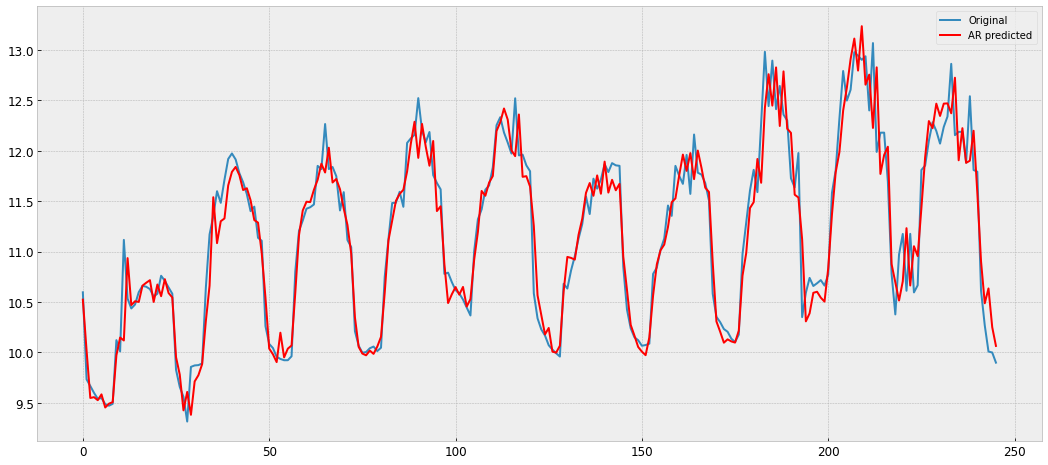

In [42]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

### Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



In [43]:
# MA example
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Energy Meter Total Active Power'], order=(0, 0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['MA'] = preds.values


yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 246/246 [01:14<00:00,  3.32it/s]


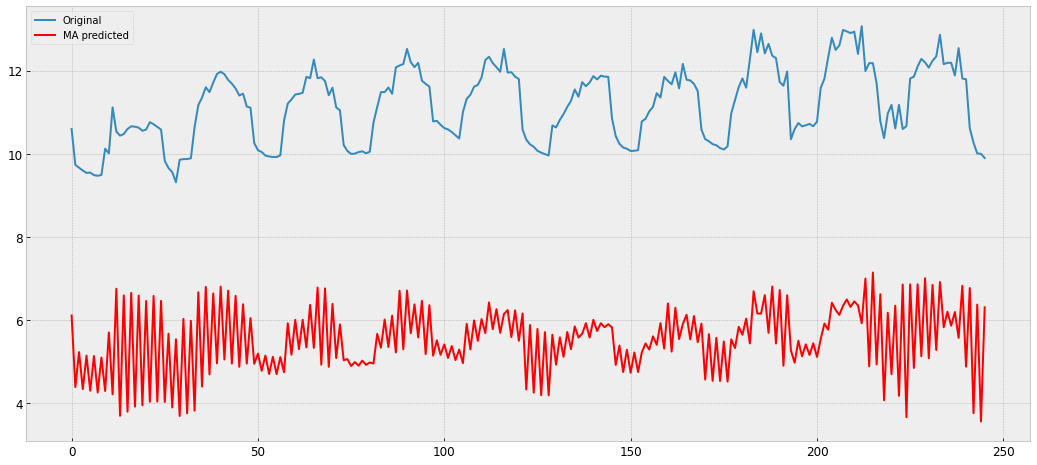

In [44]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.



In [46]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Energy Meter Total Active Power'], order=(1,1,1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['ARMA'] = preds.values


yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 246/246 [01:36<00:00,  2.54it/s]


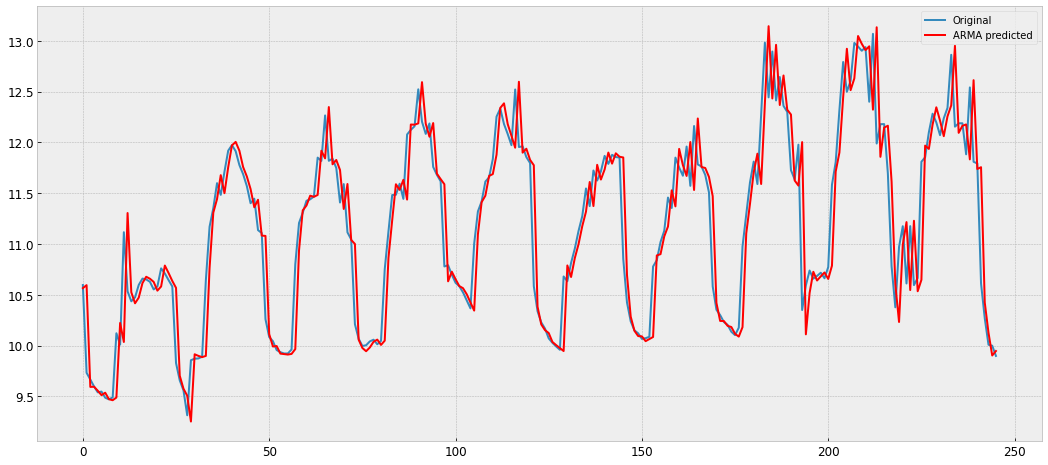

In [47]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [48]:
# ARIMA example
import statsmodels.api as sm
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = sm.tsa.arima.ARIMA(temp_train['Energy Meter Total Active Power'], order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['ARIMA'] = preds.values


yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 246/246 [01:25<00:00,  2.88it/s]


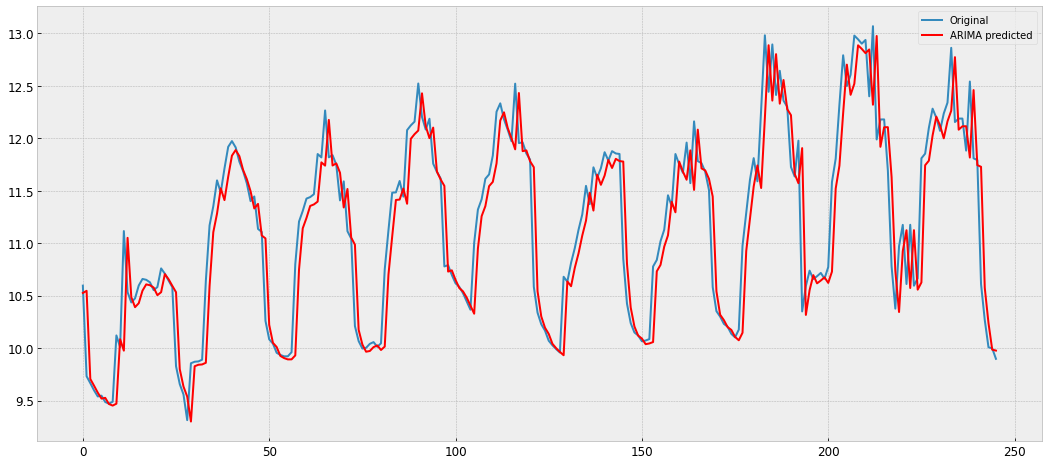

In [49]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

#### Auto ARIMA

In [50]:
# building the model

autoModel = pm.auto_arima(df_training['Energy Meter Total Active Power'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training['Energy Meter Total Active Power'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1428.880, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1491.801, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1441.152, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1450.458, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1489.811, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1426.878, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1429.852, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1425.909, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1426.839, Time=1.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1426.245, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1423.913, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1448.465, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1439.158, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1424.843, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [51]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = sm.tsa.arima.ARIMA(temp_train['Energy Meter Total Active Power'], order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['AutoARIMA'] = preds.values


yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 246/246 [01:29<00:00,  2.74it/s]


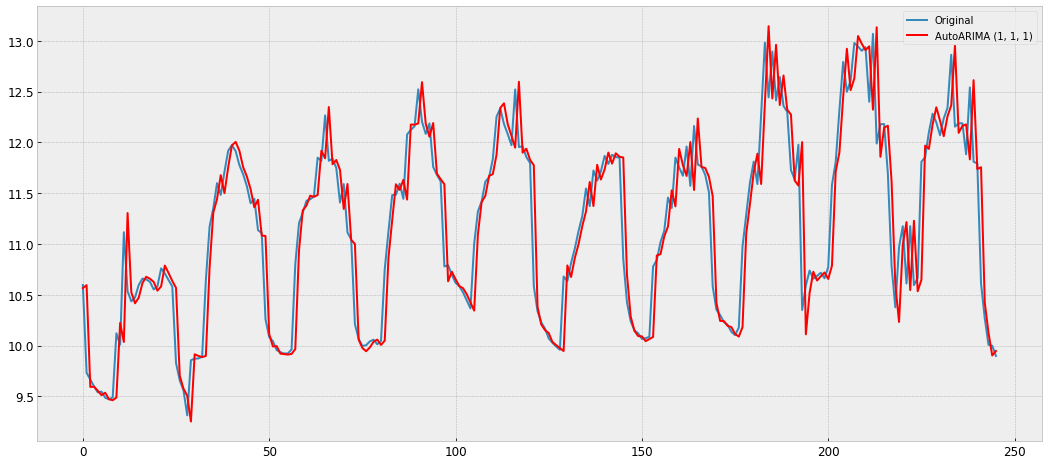

In [52]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [53]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Energy Meter Total Active Power'], order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['SARIMAX'] = preds.values

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 246/246 [00:30<00:00,  8.00it/s]


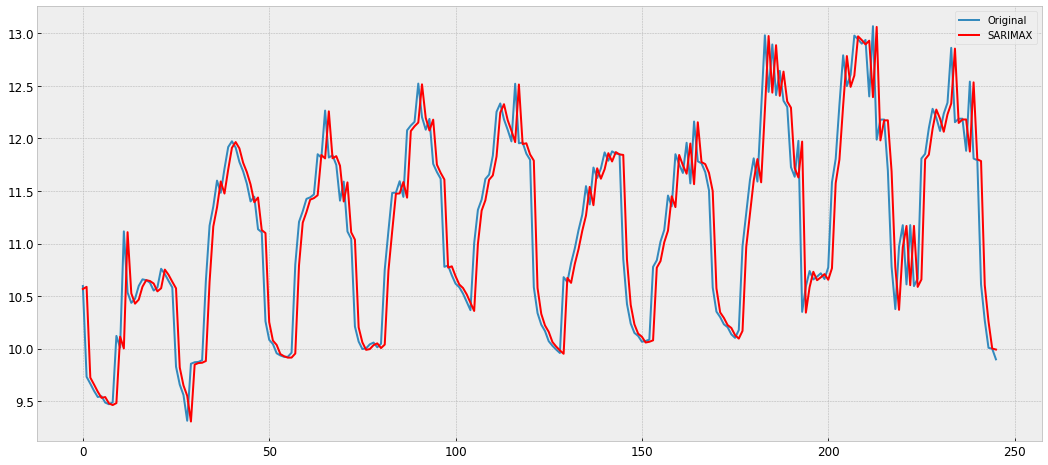

In [54]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [ ]:
# building the model
autoModel = pm.auto_arima(df_training['Energy Meter Total Active Power'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training['Energy Meter Total Active Power'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=7.02 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1491.801, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1442.899, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1452.385, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1489.811, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=1441.152, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=1442.830, Time=0.56 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=inf, Time=4.10 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=1426.245, Time=0.25 sec
 ARIMA(2,1,0)(1,0,0)[6] intercept   : AIC=1425.780, Time=1.11 sec
 ARIMA(2,1,0)(2,0,0)[6] intercept   : AIC=1416.029, Time=2.13 sec
 ARIMA(2,1,0)(2,0,1)[6] intercept   : AIC=inf, Time=10.34 sec
 ARIMA(2,1,0)(1,0,1)[6] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(1,1,0)(2,0,0)[6] intercept   : AIC=1423.736, Time=1.63 sec
 ARIMA(3,1,0)(2,0,0)[6] intercept   : AIC=1418.025, 

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [55]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test['Energy Meter Total Active Power']))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train['Energy Meter Total Active Power'], order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    preds = model_fit.forecast(246)
    Forecast_Results['AutoSARIMAX'] = preds.values
    

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test['Energy Meter Total Active Power'], yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████| 246/246 [01:35<00:00,  2.58it/s]


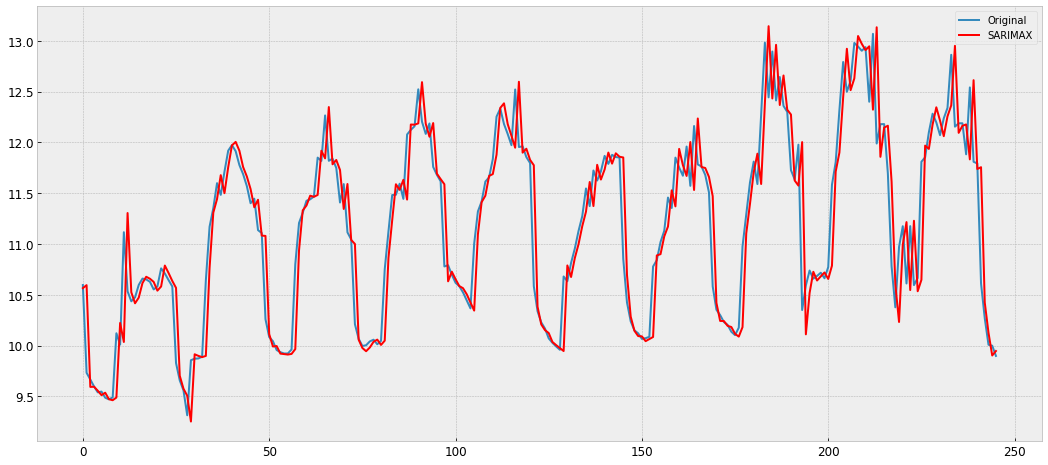

In [56]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

In [57]:
Forecast_Results

,SES,HWES,AR,MA,ARMA,ARIMA,AutoARIMA,SARIMAX,AutoSARIMAX
0,9.999,9.999,10.064391,6.307315,9.946709,9.977060,9.946709,9.991581,9.946709
1,9.999,9.999,10.240425,0.000000,9.913901,9.955663,9.913901,9.984168,9.913901
2,9.999,9.999,10.102348,0.000000,9.893316,9.934796,9.893316,9.976761,9.893316
3,9.999,9.999,10.290943,0.000000,9.880401,9.914444,9.880401,9.969358,9.880401
4,9.999,9.999,10.965639,0.000000,9.872298,9.894596,9.872298,9.961962,9.872298
...,...,...,...,...,...,...,...,...,...
241,9.999,9.999,10.222828,0.000000,9.858653,9.114126,9.858653,8.355072,9.858653
242,9.999,9.999,10.287463,0.000000,9.858653,9.114075,9.858653,8.348873,9.858653
243,9.999,9.999,10.396418,0.000000,9.858653,9.114025,9.858653,8.342679,9.858653
244,9.999,9.999,10.543821,0.000000,9.858653,9.113977,9.858653,8.336489,9.858653


### Prophet

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.


In [58]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'Energy Meter Total Active Power': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'Energy Meter Total Active Power': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [59]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='China')

In [60]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test['Energy Meter Total Active Power'], yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

In [61]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(hours=x) for x in range(0,247) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [62]:
future_dates.reset_index(inplace=True)

In [63]:
Forecast_Results['ds']=future_dates['index']

In [64]:
...
# summarize the forecast
prediction = prophet.predict(prophet_test)

In [65]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
241,2022-06-02 02:00:00,10.850646,10.599527,11.112653
242,2022-06-02 03:00:00,11.027863,10.746433,11.277744
243,2022-06-02 04:00:00,11.343907,11.078427,11.613648
244,2022-06-02 05:00:00,11.660547,11.396899,11.921224
245,2022-06-02 06:00:00,11.910094,11.640783,12.174862


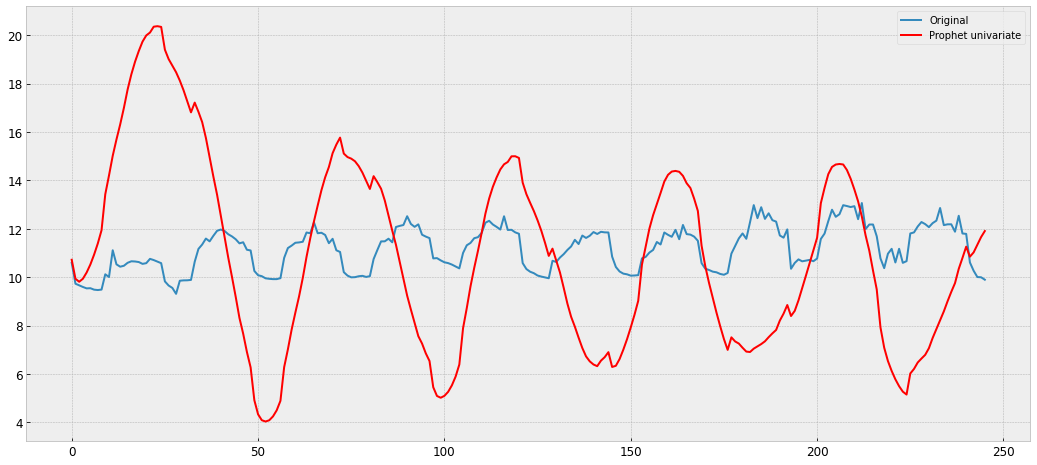

In [66]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

## Multivariate time series forecasting

In [67]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [68]:
X_train_df, y_train = create_time_features(
    df_training, target='Energy Meter Total Active Power')
X_test_df, y_test = create_time_features(df_test, target='Energy Meter Total Active Power')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [69]:
X_train_df.columns

Index(['HVAC Compressor 1 Status', 'HVAC Compressor Status',
       'HVAC Damper 1 Position', 'HVAC Delta_T', 'HVAC Fan 1 Fail',
       'HVAC Free-Cool Status', 'HVAC Heater 1 Status', 'HVAC Heater Status',
       'HVAC Indoor Temperature', 'HVAC Outdoor Temperature',
       'HVAC Supply Air Temperature 1', 'HVAC Supply Fan 1 Speed',
       'HVAC System Mode', 'power_previous', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth',
       'weekofyear'],
      dtype='object')

### Linear models

#### Bayesian regression

In [71]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['BayesianRidge'] = yhat
Forecast_Results['BayesianRidge'] = yhat

#### Lasso

In [72]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['Lasso'] = yhat
Forecast_Results['lasso'] = yhat

### Tree models

#### Randomforest

In [73]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['Randomforest'] = yhat
predictionsDict['Randomforest'] = yhat

#### XGBoost

In [74]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['XGBoost'] = yhat
Forecast_Results['XGBoost']=yhat

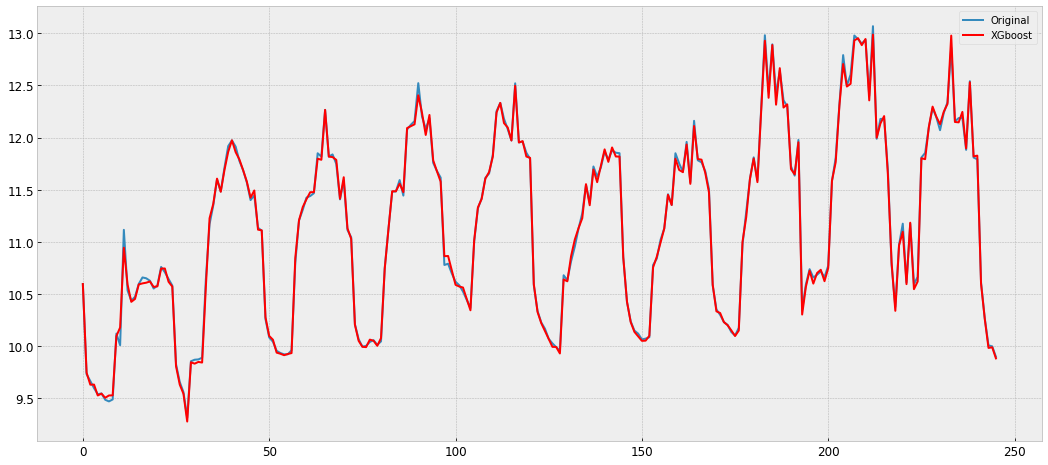

In [75]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [76]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['Lightgbm'] = yhat
Forecast_Results['Lightgbm']=yhat

### Support vector machines

Explain multiple kernels balbla

In [77]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['SVM RBF'] = yhat
Forecast_Results['svm']=yhat

### Nearest neighbors

In [78]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['Kneighbors'] = yhat
Forecast_Results['knn']=yhat

### Prophet multivariate

In [95]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [96]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [99]:
yhat.yhat.values

array([10.59482752,  9.73687152,  9.66292488,  9.59674082,  9.5399108 ,
        9.54760651,  9.48789374,  9.47415976,  9.48511158, 10.13036004,
       10.18358637, 10.94769334, 10.54049519, 10.43538944, 10.47881602,
       10.60041021, 10.65837933, 10.6376216 , 10.64688794, 10.55128827,
       10.57966629, 10.76607856, 10.71440171, 10.64250368, 10.57525873,
        9.83056586,  9.65561089,  9.55751236,  9.3089155 ,  9.85596268,
        9.87173563,  9.87647558,  9.8948469 , 10.62821279, 11.18083471,
       11.35035289, 11.59819077, 11.49115661, 11.71016179, 11.91969017,
       11.98125475, 11.89550614, 11.78230642, 11.69441122, 11.56122317,
       11.41670921, 11.45166178, 11.13222487, 11.09507554, 10.27899257,
       10.07864374, 10.04096338,  9.95656962,  9.93285702,  9.92575103,
        9.9249189 ,  9.96377418, 10.79694105, 11.20338243, 11.31947836,
       11.39906611, 11.4717365 , 11.46099582, 11.85304908, 11.80482983,
       12.26919956, 11.82729246, 11.83406092, 11.75988298, 11.41

In [103]:
Forecast_Results

,SES,HWES,AR,MA,ARMA,ARIMA,AutoARIMA,SARIMAX,AutoSARIMAX,ds,BayesianRidge,lasso,XGBoost,Lightgbm,svm,knn,Multi prophet
0,9.999,9.999,10.064391,6.307315,9.946709,9.977060,9.946709,9.991581,9.946709,2022-06-02 07:00:00,10.598290,10.485742,10.596418,10.562815,10.488718,10.353083,10.594828
1,9.999,9.999,10.240425,0.000000,9.913901,9.955663,9.913901,9.984168,9.913901,2022-06-02 08:00:00,9.742216,9.684861,9.746836,9.725298,9.888385,10.044250,9.736872
2,9.999,9.999,10.102348,0.000000,9.893316,9.934796,9.893316,9.976761,9.893316,2022-06-02 09:00:00,9.666936,9.613966,9.631569,9.635532,9.819283,10.022583,9.662925
3,9.999,9.999,10.290943,0.000000,9.880401,9.914444,9.880401,9.969358,9.880401,2022-06-02 10:00:00,9.597925,9.549147,9.632437,9.591841,9.756435,10.023083,9.596741
4,9.999,9.999,10.965639,0.000000,9.872298,9.894596,9.872298,9.961962,9.872298,2022-06-02 11:00:00,9.539290,9.493989,9.528147,9.516633,9.703034,9.459750,9.539911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,9.999,9.999,10.222828,0.000000,9.858653,9.114126,9.858653,8.355072,9.858653,2022-06-12 08:00:00,10.624772,10.509253,10.601001,10.643108,10.526566,10.619702,10.619176
242,9.999,9.999,10.287463,0.000000,9.858653,9.114075,9.858653,8.348873,9.858653,2022-06-12 09:00:00,10.271028,10.177854,10.262441,10.332687,10.309671,10.407583,10.266342
243,9.999,9.999,10.396418,0.000000,9.858653,9.114025,9.858653,8.342679,9.858653,2022-06-12 10:00:00,10.011667,9.934474,9.983839,10.004226,10.145898,10.178250,10.009166
244,9.999,9.999,10.543821,0.000000,9.858653,9.113977,9.858653,8.336489,9.858653,2022-06-12 11:00:00,10.000222,9.923255,9.990100,10.019175,10.118852,10.113167,9.999303


In [101]:
Forecast_Results.to_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/time_series_power/results/Hourly_power_Forecasting.csv')

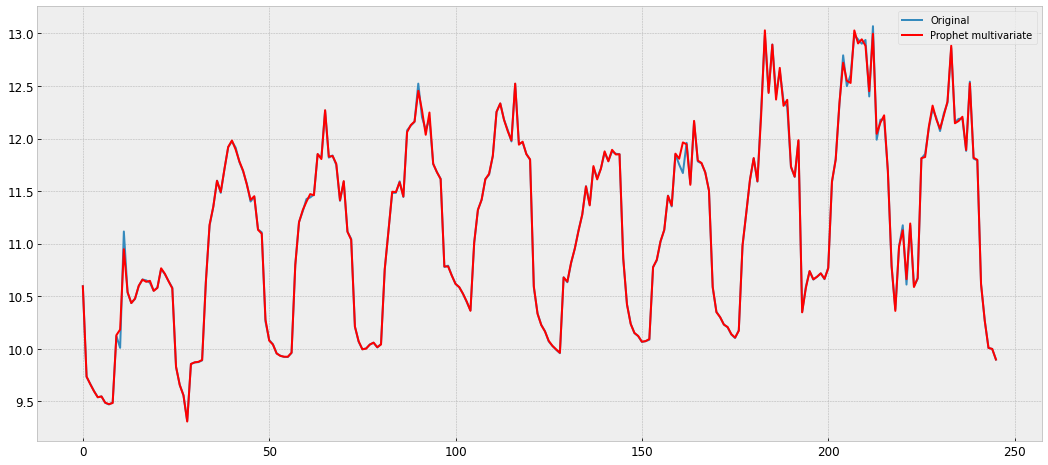

In [81]:
plt.plot(df_test['Energy Meter Total Active Power'].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [ ]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/100
200/200 [==============================] - 4s 9ms/step - loss: 1.1796 - val_loss: 1.4114
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6313 - val_loss: 1.1198
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5187 - val_loss: 0.6274
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.4535 - val_loss: 0.3390
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.4076 - val_loss: 0.7351
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3833 - val_loss: 0.6383
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3595 - val_loss: 0.3722
Epoch 8/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3326 - val_loss: 0.6859
Epoch 9/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3168 - val_loss: 0.2448
Epoch 10/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3057 - val_lo

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

#### DeepAR

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon

In [ ]:
features = ['Energy Meter Total Active Power', 'HVAC Compressor 1 Status',
       'HVAC Compressor Status', 'HVAC Damper 1 Position', 'HVAC Delta_T'
       ,'HVAC Free-Cool Status', 'HVAC Heater 1 Status',
       'HVAC Heater Status', 'HVAC Indoor Temperature',
       'HVAC Outdoor Temperature', 'HVAC Supply Air Temperature 1',
       'HVAC Supply Fan 1 Speed', 'HVAC System Mode', 'power_previous',
       'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'sin_day',
       'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler()
scaler.fit(X_train)  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training['Energy Meter Total Active Power'],
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="h"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test['Energy Meter Total Active Power'],
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="h"
)

In [ ]:
estimator = DeepAREstimator(freq="h",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.50it/s, epoch=1/5, avg_epoch_loss=1.72]
INFO:gluonts.trainer:Epoch[0] Elapsed time 5.887 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=1.722695
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.25it/s, epoch=2/5, avg_epoch_loss=0.768]
INFO:gluonts.trainer:Epoch[1] Elapsed time 4.881 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=0.768407
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.39it/s, epoch=3/5, avg_epoch_loss=0.532]
INFO:gluonts.trainer:Epoch[2] Elapsed time 4.820 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=0.532239
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.50it/s, epoch=4/5, avg_epoch_loss=0.478]
INFO:gluonts.trainer:Epoch[3] Elapsed time

In [ ]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

In [ ]:
type(predictionsDict)

dict

# Appendix

## Hyperparameter optimization

We have seen models with really low amount of parameters (Auto regression models,Linear models) or with crazy ammount (Trees,Prophet). Some models are more robust to different data types/shapes and dont need any hyperparameter optimization but some other can give you poor results if the parameters are not tunned, we can tune the model parameters to better fit our dataset properties. We can do this manually with pure knowledge about the model but this becames really hard when the model contains a lot of different parameters, this is when hyperparameter optimization comes handy.

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:

* **Grid search** Brute force method to try all different possible combinations of parameters. Will always find the best combination
* **Bayesian processes** "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values. Really nice library for python https://github.com/fmfn/BayesianOptimization, this method will not always find the best combination of parameters

We provide 1 example for each method

### Grid search - SVM

With grid search we can use the handy sklearn implementation

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test['Energy Meter Total Active Power'], yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [ ]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 75.73983719883202% better than the SVM with default parameters


### Bayesian processes - Xgboost

In [ ]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.8263   |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        | -0.7195   |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        | -0.8503   |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        | -0.7638   |  4.298    |  3.175    |  5.441    |  3.52e+03 |
|  5        | -0.8509   |  7.494    |  2.891    |  3.733    |  3.524e+0 |
|  6        | -0.7835   |  4.598    |  2.344    |  4.794    |  3.52e+03 |
|  7        | -0.8495   |  7.634    |  2.231    |  3.141    |  3.52e+03 |
|  8        | -0.5488   |  3.891    |  2.847    |  7.469    |  3.52e+03 |
|  9        | -0.5491   |  3.282    |  3.904    |  7.719    |  3.525e+0 |
|  10       | -0.5485   |  3.749    |  1.794    |  6.669    |  3.529e+0 |
|  11       | -0.8093   |  7.249    |  1.439    |  7.67     |  3.531e+0 |
|  12       | -0.8024   |  6.627    | 

In [ ]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [ ]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 50.460977540813005% better than the Randomforest with default parameters


## Ensembling

Ensembling refers to combine multiple models to achieve a better performance, most of the time this only makes sense when models have similar performance but predict values differently so we try to get the best of each model.

We will pick our 3 top performing models and look at the correlation of their residuals, the less correlated the better

In [ ]:
models = ['Tensorflow simple LSTM',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: df_test['Energy Meter Total Active Power'].values -
                     v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.150560,0.200000
Lightgbm,0.150560,1.000000,0.130353
XGBoost,0.200000,0.130353,1.000000


We can see how both tree models are a bit similar ~0.87 but quite different from the Deep Learning model with corr ~0.7. In this case it would really make sense to ensemble the methods and see how they behave. The most reasonable combinations to try would be

* XGboost + Tensorflow
* XGBoost + Lightgbm
* Lightgbm + Tensorflow
* XGBoost + Lightgbm + Tensorflow

We will just sum the predictions of each model with similar weights (0.5 if two models, 0.333 if three)

In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (
    predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(
    df_test['Energy Meter Total Active Power'].values, predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] +
                                          predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(
    df_test['Energy Meter Total Active Power'].values, predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (
    predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(
    df_test['Energy Meter Total Active Power'].values, predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost'] +
                                    predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(
    df_test['Energy Meter Total Active Power'].values, predictionsDict['EnsembleXG+TF'])

In [ ]:

with open('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Feature importance

Some models allow for for native feature importance algorithms but I personally like the library [SHAP](https://github.com/slundberg/shap) that provides a game theory approach to measure how each feature affects our forecast.

Here is an example on how to use SHAP for our Lightgbm model

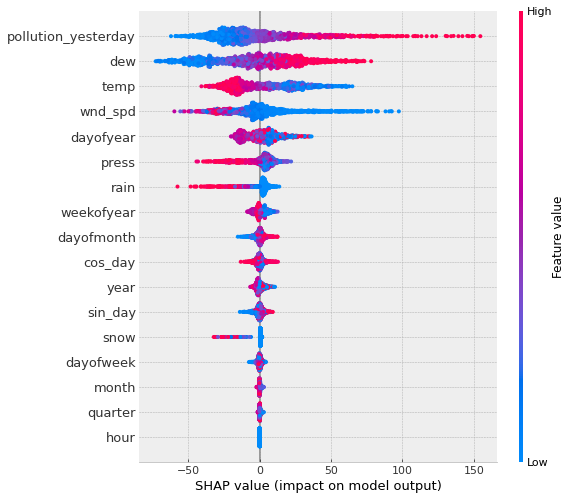

In [ ]:
explainer = shap.TreeExplainer(lightGBM)
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_train_df)

In [ ]:
df = pd.DataFrame.from_dict(resultsDict).transpose().iloc[::-1]
df = df.round(2)
df.to_csv("results/results_summary.csv")

In [ ]:
df.to_html("results/results_summary.html")